# Week 3

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats 
from pandas_datareader import data 
from datetime import datetime
from scipy.optimize import minimize

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import edhec_risk_kit as erk

In [4]:
# using seaborn style (type plt.style.available to see available styles)
plt.style.use("seaborn-dark")

## Portfolio diversification
Things about diversification:

1. diversification **is not** an effective way to decrease downside risk: in fact, conditional upon market downturns, correlation levels tend to increase and diversification benefits tend to disappear;
2. diversification is an effective way to increase the reward per unit of risk;
3. diversification is an effective way to decrease **idiosyncratic or specific** risk: in fact, it allows investors to reduce specific risk within their portfolios, which is how they can achieve a high reward per unit of risk.
4. diversification **is not** an effective way to decrease the **systemic risk**: basically, if the entire market collapses, it does not really matter how much your portfolio is diversified. 

**Market capitalization** of a stock (of a company) is the **total value of the stock**, 
that is, it is the number of shares outstanding of that stock multiplied by the share price.

Let us load the Industry following datasets

In [5]:
ind_rets   = erk.get_ind_returns()
ind_nfirms = erk.get_ind_nfirms()
ind_size   = erk.get_ind_size() 

In [6]:
ind_rets.head(3)

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
1926-07-01,0.0056,-0.0519,0.0129,0.0293,0.1097,-0.0048,0.0808,0.0177,0.0814,0.0039,...,0.0083,0.0922,0.0206,0.0770,0.0193,-0.2379,0.0007,0.0187,0.0037,0.0520
1926-08-01,0.0259,0.2703,0.0650,0.0055,0.1001,-0.0358,-0.0251,0.0425,0.0550,0.0814,...,0.0217,0.0202,0.0439,-0.0238,0.0488,0.0539,-0.0075,-0.0013,0.0446,0.0676
1926-09-01,0.0116,0.0402,0.0126,0.0658,-0.0099,0.0073,-0.0051,0.0069,0.0533,0.0231,...,0.0241,0.0225,0.0019,-0.0554,0.0005,-0.0787,0.0025,-0.0056,-0.0123,-0.0386


The dataframe **ind_rets** contains the returns (from 1926-2018) of $30$ portfolios including different industry sectors such as food, beer, smoke, etc. Such portofolios are constructed by using weights equal to the corresponding market capitalizations. 

For example, the columns **Food** contains the returns of a portfolio consisting of all the companies in the food sectors for each month from 1926 to 2019. The portfolio has been constructed by weighting each company according to its market capitalization.

Now, the number of firms composing each single sector are stored in **ind_nfirms**:

In [7]:
ind_nfirms.head(3)

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
1926-07-01,43,3,16,7,2,8,12,7,17,13,...,5,3,7,6,74,2,33,6,12,4
1926-08-01,43,3,16,7,2,8,12,7,17,13,...,5,3,7,6,74,2,33,6,12,4
1926-09-01,43,3,16,7,2,8,12,7,17,13,...,5,3,7,6,74,2,33,6,12,4


that is, in 1926-07, there were 43 (food) companies in the Food portfolio, 3 (beer) companies in the Beer portfolio, etc.

Finally, the datframe **ind_size** contains the **average size** of the companies composing the portfolio:

In [8]:
ind_size.head(3)

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
1926-07-01,35.98,7.12,59.72,26.41,12.02,22.27,18.36,25.52,57.59,6.18,...,350.36,13.60,56.70,35.35,66.91,1.19,46.65,10.82,18.83,24.25
1926-08-01,36.10,6.75,60.47,27.17,13.33,22.13,19.83,25.80,62.13,6.20,...,353.27,14.75,57.74,37.86,67.99,0.90,46.57,11.00,18.88,25.51
1926-09-01,37.00,8.58,64.03,27.30,14.67,21.18,19.29,26.73,65.53,6.71,...,360.96,15.05,59.61,36.82,71.02,0.95,46.11,10.94,19.67,27.21


that is, the average size of the 43 Food companies in 1926-07 was 35.98, the average size of the 3 Beer companies was 7.12, ans so on (it does not matter the unit). 
By **average size** we mean the **average of the market capitalizations** of the 43 food companies, of the 3 Beer companies, etc.

#### Constructing the index
The first thing to do is to get the market capitalization of each industry sector. 
This is simply given by the number of firms times their average size:

In [9]:
ind_mkt_cap = ind_nfirms * ind_size
ind_mkt_cap.head(3)

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
1926-07-01,1547.14,21.36,955.52,184.87,24.04,178.16,220.32,178.64,979.03,80.34,...,1751.80,40.80,396.90,212.10,4951.34,2.38,1539.45,64.92,225.96,97.00
1926-08-01,1552.30,20.25,967.52,190.19,26.66,177.04,237.96,180.60,1056.21,80.60,...,1766.35,44.25,404.18,227.16,5031.26,1.80,1536.81,66.00,226.56,102.04
1926-09-01,1591.00,25.74,1024.48,191.10,29.34,169.44,231.48,187.11,1114.01,87.23,...,1804.80,45.15,417.27,220.92,5255.48,1.90,1521.63,65.64,236.04,108.84


Now, we want to get the **total market capitalization**, in order to get the fraction of the 
total market capitalization which is in each industry. The total market capitalization
is a signle time series **representing the total value of the market at each month**. 
This can be obtained by summing each market capitalization of each sector every month, i.e., 
by summing the horizontally the **ind_mkt_cap**:

In [24]:
# total market capitalization: 
total_mkt_cap = ind_mkt_cap.sum(axis=1)
print(total_mkt_cap.head(3))

# and now, we can divide each single market cap by the total market cap 
ind_cap_weights = ind_mkt_cap.divide(total_mkt_cap, axis=0)
ind_cap_weights.head(3)

1926-07-01    26657.94
1926-08-01    27436.34
1926-09-01    28060.41
dtype: float64


,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
1926-07-01,0.058037,0.000801,0.035844,0.006935,0.000902,0.006683,0.008265,0.006701,0.036726,0.003014,...,0.065714,0.001531,0.014889,0.007956,0.185736,0.000089,0.057748,0.002435,0.008476,0.003639
1926-08-01,0.056578,0.000738,0.035264,0.006932,0.000972,0.006453,0.008673,0.006583,0.038497,0.002938,...,0.064380,0.001613,0.014732,0.008280,0.183379,0.000066,0.056014,0.002406,0.008258,0.003719
1926-09-01,0.056699,0.000917,0.036510,0.006810,0.001046,0.006038,0.008249,0.006668,0.039700,0.003109,...,0.064318,0.001609,0.014870,0.007873,0.187292,0.000068,0.054227,0.002339,0.008412,0.003879


This means that, for example, in 1926-07 the total market capitalization was $26657.94$ and that 
the Food companies (in the portfolio for this month) represented all together about the $5.8\%$, 
the Beer companies (in the portfolio for this month) represented all together about the $0.08\%$, and so on.

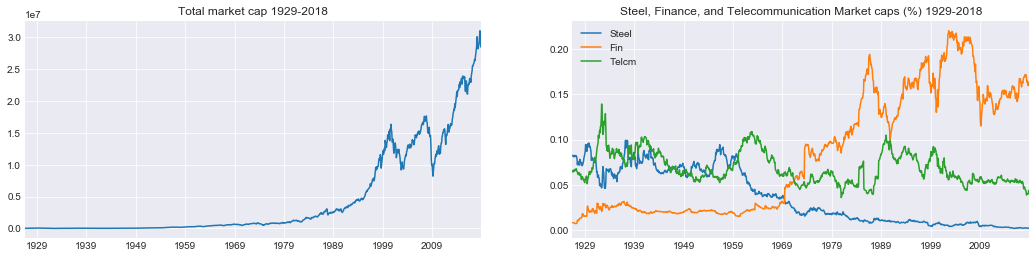

In [47]:
fig, ax = plt.subplots(1,2,figsize=(18,4)) 
total_mkt_cap.plot(grid=True, ax=ax[0]) 
ax[0].set_title("Total market cap 1929-2018")

ind_cap_weights[["Steel","Fin","Telcm"]].plot(grid=True, ax=ax[1])
ax[1].set_title("Steel, Finance, and Telecommunication Market caps (%) 1929-2018")
plt.show()

In the plot on the left we have the total market cap form 1929 to 2018. On the right, we have the Steel, Finance, and Telecommunication Market 
caps 1929-2018 as a percentage of the total market cap. 

For example, notice that while the Finance sector was around the $3\%$ of the total market cap in 1929, in 2018 it was more than $15\%$. 
On the other hand, the Stell sector was around the $9\%$ in 1929 until decreasing to the $0.2\%$ in 2018.

Now, let us find the **total maket return**, i.e., the return time series from the total market. 
This is simply going to be the sum of the weights of each sector times their corresponding monthly returns.

Once we have the total market return series, we can **compound** it and obtain 
the **total market index** (what we called the **wealth** in week 1):

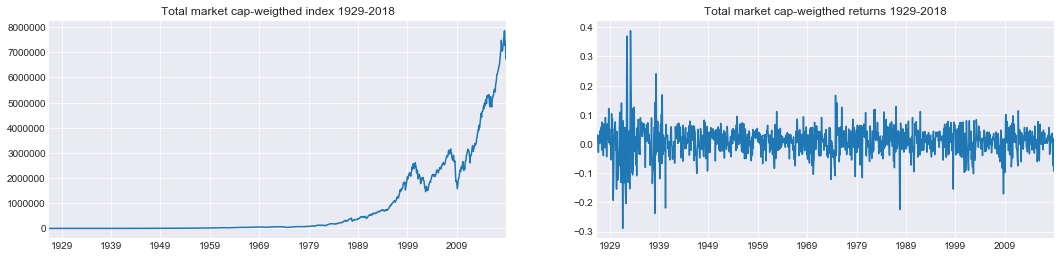

In [69]:
total_market_return = (ind_cap_weights * ind_rets).sum(axis=1)

# suppose to have invested a capital of 1000$ in the market
capital = 1000
total_market_index = capital * (1 + total_market_return).cumprod()

fig, ax = plt.subplots(1,2,figsize=(18,4)) 

total_market_index.plot(grid=True, ax=ax[0]) 
ax[0].set_title("Total market cap-weigthed index 1929-2018")

total_market_return.plot(grid=True, ax=ax[1])
ax[1].set_title("Total market cap-weigthed returns 1929-2018")

plt.show()

Notice that the plot of the (cap-weigthed) index is, of course, the same (but different in values) as the plot of the total market capitalization.

Next, we what to see **how returns are relatd to market correlations**.

Let us plot the total market index, say from 1980, and plot together some moving average (MA) series corresponding to 60, 36, and 12 months (i.e, 5, 3, and 1 years), repsectively.  

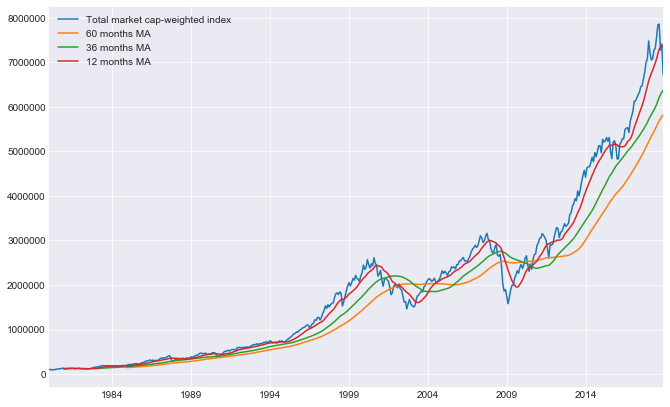

In [94]:
total_market_index["1980":].plot(grid=True, figsize=(11,7), label="Total market cap-weighted index")

total_market_index["1980":].rolling(window=60).mean().plot(grid=True, figsize=(11,7), label="60 months MA") # 5 years MA
total_market_index["1980":].rolling(window=36).mean().plot(grid=True, figsize=(11,7), label="36 months MA") # 3 years MA
total_market_index["1980":].rolling(window=12).mean().plot(grid=True, figsize=(11,7), label="12 months MA") # 1 year MA
plt.legend()
plt.show()

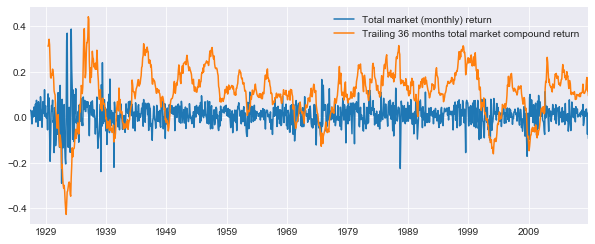

In [105]:
tmi_trail_36_rets = total_market_return.rolling(window=36).aggregate( erk.annualize_rets, periods_per_year=12 )

total_market_return.plot(grid=True, figsize=(10,4), label="Total market (monthly) return")
tmi_trail_36_rets.plot(grid=True, figsize=(10,4), label="Trailing 36 months total market compound return")

plt.legend()
plt.show()

In [113]:
total_market_return["1926-07":"1929-06"].shape

(36,)

In [115]:
erk.annualize_rets( total_market_return["1926-07":"1929-06"], 12) 

0.3129441004956104

In [114]:
tmi_trail_36_rets["1926-07":"1929-06"]

1926-07-01         NaN
1926-08-01         NaN
1926-09-01         NaN
1926-10-01         NaN
1926-11-01         NaN
1926-12-01         NaN
1927-01-01         NaN
1927-02-01         NaN
1927-03-01         NaN
1927-04-01         NaN
1927-05-01         NaN
1927-06-01         NaN
1927-07-01         NaN
1927-08-01         NaN
1927-09-01         NaN
1927-10-01         NaN
1927-11-01         NaN
1927-12-01         NaN
1928-01-01         NaN
1928-02-01         NaN
1928-03-01         NaN
1928-04-01         NaN
1928-05-01         NaN
1928-06-01         NaN
1928-07-01         NaN
1928-08-01         NaN
1928-09-01         NaN
1928-10-01         NaN
1928-11-01         NaN
1928-12-01         NaN
1929-01-01         NaN
1929-02-01         NaN
1929-03-01         NaN
1929-04-01         NaN
1929-05-01         NaN
1929-06-01    0.312944
dtype: float64

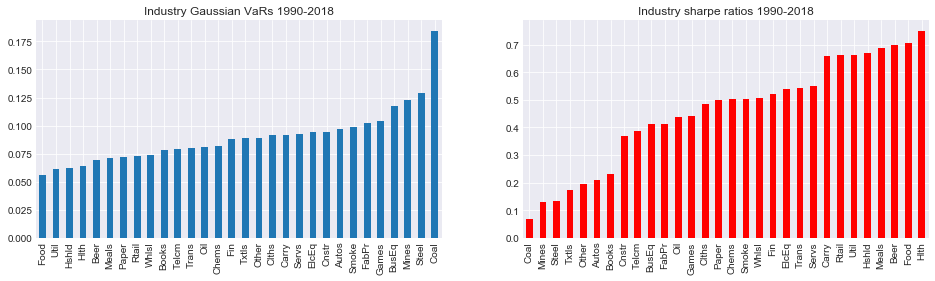

In [16]:
fig, ax = plt.subplots(figsize=(20,4), nrows=1, ncols=2)
erk.var_gaussian(ind_rets["1990":"2018"], cf=True).sort_values().plot.bar(grid=True, figsize=(16,4), ax=ax[0], title="Industry Gaussian VaRs 1990-2018")
erk.sharpe_ratio(ind_rets["1990":"2018"], 0.0, 12).sort_values().plot.bar(grid=True, figsize=(16,4), ax=ax[1], title="Industry sharpe ratios 1990-2018", color="r")
plt.show()